In [7]:
import pandas as pd
import numpy as np

In [27]:
# Muestra todas las columnas
pd.set_option('display.max_columns', None)
# Cuenta por cada variable cuantos valores unicos hay
llibres_pkl = pd.read_pickle('../llibres.pkl')
ll = ['language_code', 'format', 'estil_literari', 'complexitat', 'desenvolupament_del_personatge', 'epoca', 'detall_cientific']
llibres_pkl = llibres_pkl.applymap(lambda x: tuple(x) if isinstance(x, np.ndarray) or isinstance(x, list) else x)
# Nos quedamos solo con las columnas de ll
llibres_pkl = llibres_pkl[ll]
eo = llibres_pkl.nunique().to_list()
dic = llibres_pkl.nunique().to_dict()
eo.append(1)
eo.append(1)
eo.append(8)
dic['average_rating'] = 1
dic['num_pages'] = 1
dic['genres'] = 8
eo

[3, 4, 7, 3, 3, 3, 3, 1, 1, 8]

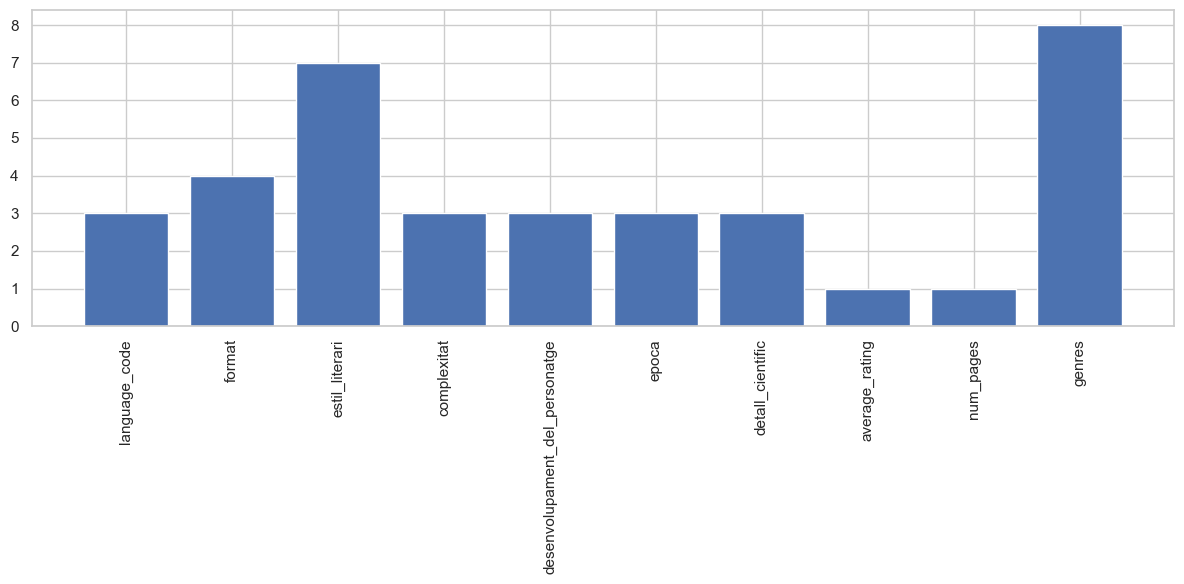

In [28]:
# Plot de las variables y su valor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.bar(dic.keys(), dic.values())
plt.xticks(rotation=90)
# Hacer que no se corten los nombres
plt.tight_layout()
plt.savefig("../../plots/numero_posicions_vector_despres.png")

In [5]:
dic

{'language_code': 3,
 'format': 4,
 'estil_literari': 7,
 'complexitat': 3,
 'desenvolupament_del_personatge': 3,
 'epoca': 3,
 'detall_cientific': 3,
 'average_rating': 1,
 'num_pages': 1,
 'genres': 8}

In [5]:
import numpy as np
from sklearn.metrics import pairwise_distances_argmin
llibres_pkl = pd.read_pickle('../llibres.pkl')

vectors = np.array(llibres_pkl.vector)
for i in range(len(vectors)):
    vectors[i] = np.array(vectors[i])
vectors = np.vstack(vectors)
print(vectors.shape)

(15666, 36)


In [6]:
import numpy as np

class KMeans_modificat():
    def __init__(self, n_clusters, weights, seed, max_iter=100):
        self.n_clusters = n_clusters
        self.weights = np.array(weights) / np.sum(weights)  # Normalizar los pesos aquí
        self.max_iter = max_iter
        self.seed = seed
        self.centroids = None
        self.labels = None
        self.inertia_ = None

    def fit_predict(self, X):
        np.random.seed(self.seed)
        centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            distances = np.sqrt(((X - centroids[:, np.newaxis]) ** 2 * self.weights).sum(axis=2))
            labels = np.argmin(distances, axis=0)
            new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(self.n_clusters)])

            if np.all(centroids == new_centroids):
                break

            centroids = new_centroids

        self.centroids = centroids
        self.labels = labels
        self._calculate_inertia(X)

        return labels

    def _calculate_inertia(self, X):
        """Calcula la inercia del modelo."""
        distances = np.sqrt(((X - self.centroids[self.labels]) ** 2 * self.weights).sum(axis=1))
        self.inertia_ = np.sum(distances ** 2)

    def predict_cluster(self, new_point):
        distances = np.sqrt(((self.centroids - new_point) ** 2 * self.weights).sum(axis=1))
        cluster_label = np.argmin(distances)
        return cluster_label

In [7]:
def calculate_optimal_k(inertia, k_range):
    """
    Calcula el valor óptimo de K utilizando el método del codo automatizado.
    :param inertia: Lista de valores de inercia para diferentes valores de K.
    :param k_range: Rango de valores de K considerados.
    :return: Valor óptimo de K.
    """
    # Coordenadas del primer y último punto
    p1 = np.array([k_range[0], inertia[0]])
    p2 = np.array([k_range[-1], inertia[-1]])

    # Distancia de cada punto a la línea
    distances = []
    for k, iner in zip(k_range, inertia):
        pk = np.array([k, iner])
        line_vec = p2 - p1
        point_vec = pk - p1
        distance = np.abs(np.cross(line_vec, point_vec)) / np.linalg.norm(line_vec)
        distances.append(distance)

    # Encontrar el índice del valor máximo de la distancia
    optimal_k_index = np.argmax(distances)
    return k_range[optimal_k_index]

In [8]:
# Ejemplo de uso
# Supongamos que X es tu conjunto de datos con 85 características y 'weights' es tu vector de pesos
np.random.seed(0)  # Para reproducibilidad
X = np.array(vectors)

from sklearn.cluster import KMeans
# Aplicando el k-means ponderado
inert = []
k_range = range(1, 21)
for x in k_range:
    #kmeans = KMeans_modificat(n_clusters=x, weights=weights, seed=0)
    kmeans = KMeans(n_clusters=x, random_state=0, n_init=10)
    kmeans.fit_predict(X)
    inert.append(kmeans.inertia_)

K optima és: 6


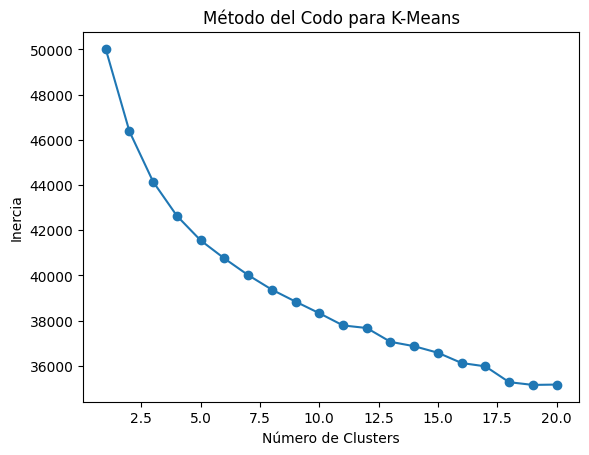

In [9]:
k_optima = calculate_optimal_k(inert, k_range)
print(f"K optima és: {k_optima}")

import matplotlib.pyplot as plt
plt.plot(k_range, inert, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

In [10]:
kmeans = KMeans(n_clusters=int(k_optima), random_state=0, n_init=10)
kmeans.fit_predict(X)

array([3, 5, 0, ..., 1, 5, 1], dtype=int32)

In [11]:
# Calcular matriz distancia euclidea entre los centroides
from sklearn.metrics import pairwise_distances
centroids = kmeans.cluster_centers_
distances = pairwise_distances(centroids, metric='euclidean')
print(distances.shape)
distances

(6, 6)


array([[0.        , 1.31408479, 0.91540643, 1.13241965, 1.11498464,
        1.11510725],
       [1.31408479, 0.        , 1.0565126 , 1.54979781, 1.1374423 ,
        1.21595215],
       [0.91540643, 1.0565126 , 0.        , 1.44232597, 1.32909401,
        1.22125439],
       [1.13241965, 1.54979781, 1.44232597, 0.        , 1.13897927,
        0.97591394],
       [1.11498464, 1.1374423 , 1.32909401, 1.13897927, 0.        ,
        1.03057169],
       [1.11510725, 1.21595215, 1.22125439, 0.97591394, 1.03057169,
        0.        ]])

In [12]:
labels = kmeans.labels_

In [13]:
llibres_pkl['cluster'] = labels
llibres_pkl.to_csv('../llibres.csv', index=False)
llibres_pkl.to_pickle('../llibres.pkl')
import pickle
with open('model_clustering_llibres.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

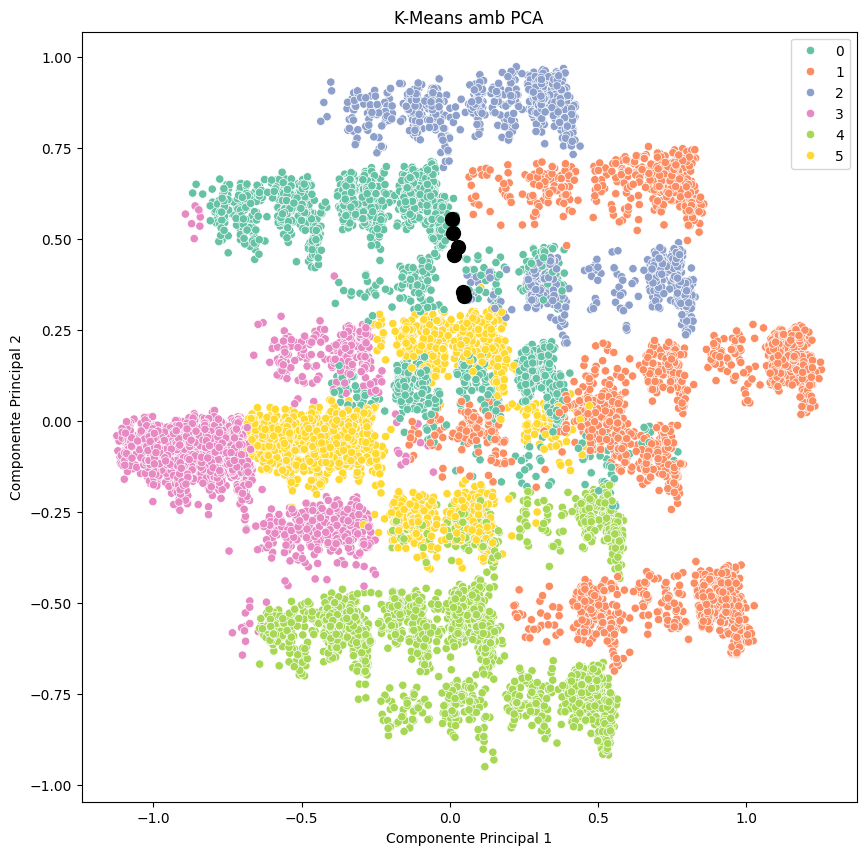

In [14]:
# Plot PCA 2d
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_pca.shape

# Plot PCA 2d and centroids
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids')
plt.title('K-Means amb PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.savefig('../../plots/kmeans_pca_llibres.png')

In [15]:
from sklearn.decomposition import PCA
df_vector = pd.DataFrame(llibres_pkl['vector'].tolist())

# Columna de clusters
df_cluster = pd.DataFrame(labels, columns=['cluster'])

# PCA with 3 components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df_vector)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])

# Unir los componentes principales con la información del cluster
finalDf = pd.concat([principalDf, df_cluster], axis=1)

# Plot a 3D interactive plot
import plotly.express as px
fig = px.scatter_3d(finalDf, x='PC1', y='PC2', z='PC3', color='cluster')
# Plot centroids
fig.add_scatter3d(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], z=kmeans.cluster_centers_[:, 2], mode='markers', marker=dict(size=10, color='black', opacity=1))

# Guardar el gráfico
fig.write_html('../../plots/pca_llibres_cluster_3d.html')
fig.show()

In [16]:
casos = pd.read_pickle('../casos.pkl')

In [17]:
X = np.vstack(np.array(casos.vector))
print(X.shape)

from sklearn.cluster import KMeans
# Aplicando el k-means ponderado
inert = []
k_range = range(1, 21)
for x in k_range:
    #kmeans = KMeans_modificat(n_clusters=x, weights=weights, seed=0)
    kmeans = KMeans(n_clusters=x, random_state=0, n_init=10)
    kmeans.fit_predict(X)
    inert.append(kmeans.inertia_)

(1601, 36)


K optima és: 6


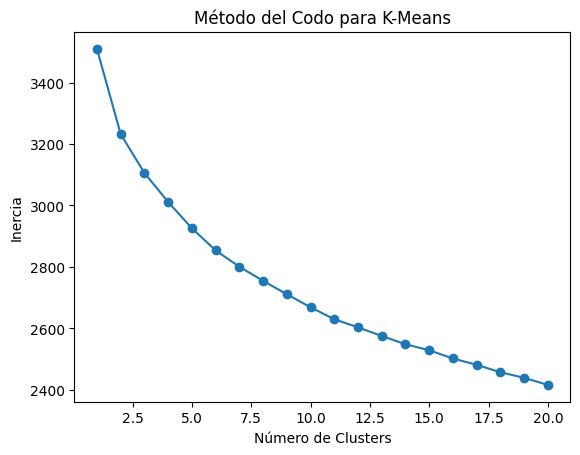

In [18]:
k_optima = calculate_optimal_k(inert, k_range)
print(f"K optima és: {k_optima}")

import matplotlib.pyplot as plt
plt.plot(k_range, inert, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

In [19]:
kmeans = KMeans(n_clusters=int(k_optima), random_state=0, n_init=10)
kmeans.fit_predict(X)

array([5, 0, 4, ..., 2, 4, 0], dtype=int32)

In [20]:
labels = kmeans.labels_

In [21]:
# Calcular matriz distancia euclidea entre los centroides
from sklearn.metrics import pairwise_distances
centroids = kmeans.cluster_centers_
distances = pairwise_distances(centroids, metric='euclidean')
print(distances.shape)
distances

(6, 6)


array([[0.        , 1.01632759, 0.86864429, 1.1016468 , 0.87241709,
        0.83450529],
       [1.01632759, 0.        , 0.95765926, 1.25599945, 1.36745984,
        0.97308803],
       [0.86864429, 0.95765926, 0.        , 1.18196157, 0.99019151,
        0.87489641],
       [1.1016468 , 1.25599945, 1.18196157, 0.        , 0.83682003,
        1.09778334],
       [0.87241709, 1.36745984, 0.99019151, 0.83682003, 0.        ,
        0.94167025],
       [0.83450529, 0.97308803, 0.87489641, 1.09778334, 0.94167025,
        0.        ]])

In [22]:
casos['cluster'] = labels
casos.to_csv('../casos.csv', index=False)
casos.to_pickle('../casos.pkl')
import pickle
with open('model_clustering_casos.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

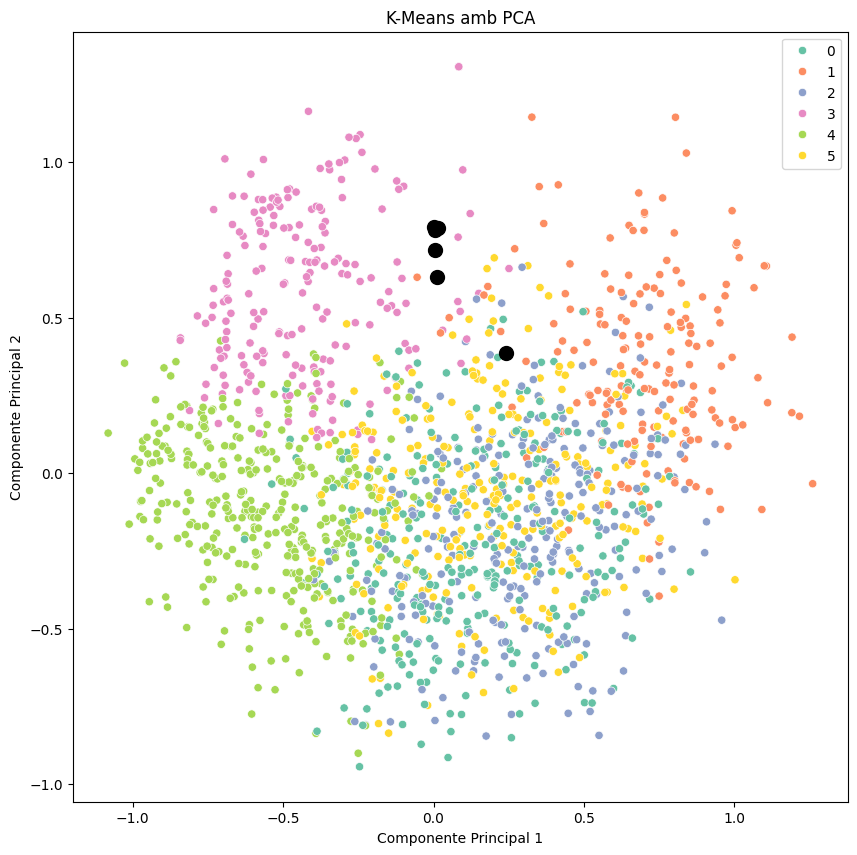

In [23]:
# Plot PCA 2d
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_pca.shape

# Plot PCA 2d and centroids
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids')
plt.title('K-Means amb PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.savefig('../../plots/kmeans_pca_casos.png')

In [24]:
from sklearn.decomposition import PCA
df_vector = pd.DataFrame(llibres_pkl['vector'].tolist())

# Columna de clusters
df_cluster = pd.DataFrame(labels, columns=['cluster'])

# PCA with 3 components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df_vector)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])

# Unir los componentes principales con la información del cluster
finalDf = pd.concat([principalDf, df_cluster], axis=1)

# Plot a 3D interactive plot
import plotly.express as px
fig = px.scatter_3d(finalDf, x='PC1', y='PC2', z='PC3', color='cluster')
# Plot centroids
fig.add_scatter3d(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], z=kmeans.cluster_centers_[:, 2], mode='markers', marker=dict(size=10, color='black', opacity=1))

# Guardar el gráfico
fig.write_html('../../plots/pca_casos_cluster_3d.html')
fig.show()